In [1]:
import os
import pandas as pd
import scanpy as sc
import anndata as ad
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager as fm


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")
sc.set_figure_params(fontsize=6,frameon=False)
sc.settings.vector_friendly = False


scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


## Generate Raw File

In [3]:
# Set the working directory
os.chdir("Final_Notebooks/Final_Objects/")

# Load mitochondrial genes list
mito_genes = [
    "ND1", "ND2", "COX1", "COII", "ATP8", "ATP6", "COX3", "ND3", "ND4L", "ND4", "ND5", "CYTB", "ND6"
]

# Define sample lists
samples_list1 = [
    "Expt9_Mix1", "Expt9_Mix2", "Expt10_Mix3", "Expt10_Mix4", "Expt11_Mix5", "Expt11_Mix6", "Expt12_Mix7", "Expt12_Mix8"
]
samples_list2 = ["1", "2", "3", "4", "5", "6"]

def prepare_datasets(counts_path, project_name, exp_id):
    adata_list = []
    exp_parts = exp_id.split('_')
    exp_number = exp_parts[0].split('Expt')[1]
    for sample in samples_list2:
        data_dir = Path(counts_path) / exp_parts[0] / "source" / exp_parts[1] / f"{exp_number}_{sample}" / "sample_filtered_feature_bc_matrix"
        print(f"Processing {data_dir}")
        adata = sc.read_10x_mtx(str(data_dir), var_names='gene_symbols', cache=True)
        adata.var['mito'] = adata.var_names.str.startswith(tuple(mito_genes))
        adata.obs['ExperimentID'] = exp_id
        adata.obs['ConditionID'] = sample
        adata_list.append(adata)
    return adata_list

adata_full_list = []
for sample1 in samples_list1:
    print(f"Processing {sample1}")
    adata_full_list.extend(prepare_datasets("./cellranger_demux_counts/", "BTP2", sample1))

Processing Expt9_Mix1
Processing cellranger_demux_counts/Expt9/source/Mix1/9_1/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing cellranger_demux_counts/Expt9/source/Mix1/9_2/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing cellranger_demux_counts/Expt9/source/Mix1/9_3/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing cellranger_demux_counts/Expt9/source/Mix1/9_4/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing cellranger_demux_counts/Expt9/source/Mix1/9_5/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing cellranger_demux_counts/Expt9/source/Mix1/9_6/sample_filtered_feature_bc_matrix
... writing an h5ad cache file to speedup reading next time
Processing Expt9_Mix2
Processing cellranger_demux_counts/Expt9/source/Mi

In [4]:
os.chdir("../../")


In [5]:
#Save Raw h5ad Object
adata_combined = ad.concat(adata_full_list, axis=0, join='outer')
adata_combined.var_names_make_unique()
adata_combined.obs_names_make_unique()
adata_combined.write_h5ad('Final_Notebooks/Final_Objects/PBMC_raw.h5ad')

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### QC Filtering

In [6]:
#To replicate scrublet results you will need to downgrade scanpy to 1.9.8
for adata in adata_full_list:
    # Filter cells and genes according to specified thresholds
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.filter_cells(adata, min_genes=500)
    sc.pp.filter_cells(adata, min_counts=1000)
    
    sc.pp.scrublet(adata=adata)


filtered out 22959 genes that are detected in less than 10 cells
filtered out 156 cells that have less than 500 genes expressed
filtered out 14 cells that have less than 1000 counts
Running Scrublet
filtered out 1 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 47.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%
    Scrublet finished (0:00:11)
filtered out 22804 genes that are detected in less 

In [7]:
for i, adata in enumerate(adata_full_list):
    if not adata.obs_names.is_unique:
        adata.obs_names_make_unique(join="-")
    if not adata.var_names.is_unique:
        adata.var_names_make_unique(join="-")
        
adata_combined = ad.concat(adata_full_list, axis=0, join='outer')
adata_combined.var_names_make_unique()
adata_combined.obs_names_make_unique()

/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
# Processing annotations
experiment_labels = adata_combined.obs['ExperimentID'].str.split('_', expand=True)[0]
donor_map = {
    "Expt9": "Donor1", "Expt10": "Donor2", "Expt11": "Donor3", "Expt12": "Donor4"
}
adata_combined.obs['Donor'] = experiment_labels.map(donor_map).astype('category')

condition_map = {
    "1": "Control", "2": "PHA", "3": "BTP2", "4": "PHA + BTP2", "5": "CM4620", "6": "PHA + CM4620"
}
adata_combined.obs['Condition'] = adata_combined.obs['ConditionID'].map(condition_map).astype('category')
adata_combined.obs['sample'] = adata_combined.obs['Donor'].astype(str) + '---' + adata_combined.obs['Condition'].astype(str)

In [9]:
adata_combined.write_h5ad('Final_Notebooks/Final_Objects/PBMC_Unprocessed.h5ad')

In [10]:
adata_combined=sc.read_h5ad('Final_Notebooks/Final_Objects/PBMC_Unprocessed.h5ad')

## Subset for Control only

In [11]:

adata_combined = adata_combined[adata_combined.obs['Condition'].isin(['Control'])]
adata = adata_combined.copy()
adata

AnnData object with n_obs × n_vars = 24348 × 16537
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample'

In [12]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

### Visualize QC metrics

In [13]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

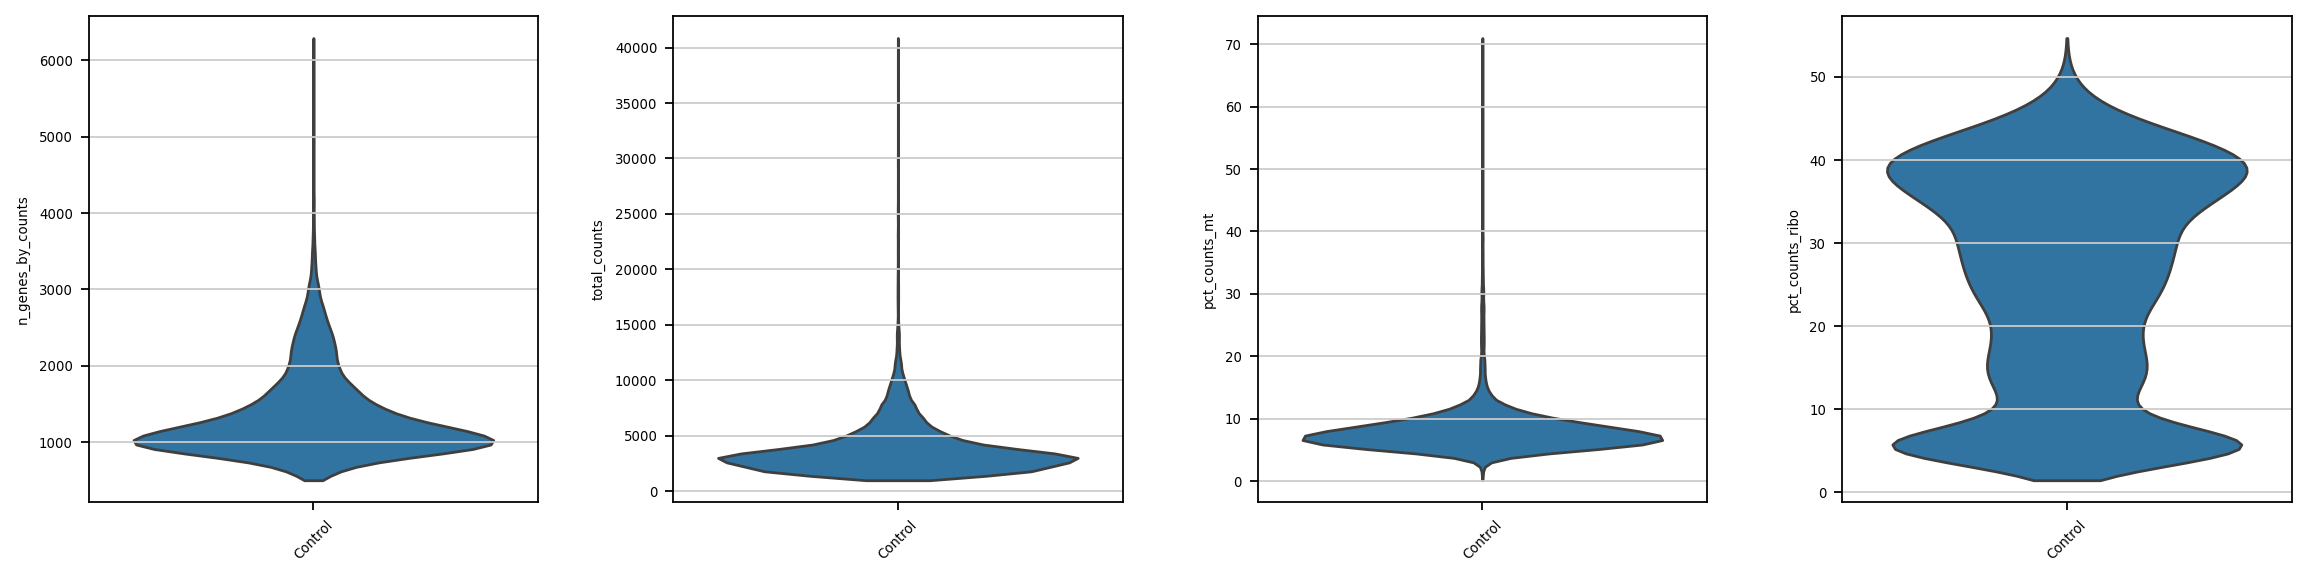

In [14]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo"],
    jitter=0.4,
    groupby = 'Condition',
    multi_panel=True,
    stripplot=False,rotation=45
)

In [15]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    24148
True       200
Name: count, dtype: int64

### Cluster before removing doublets

In [16]:
# Save raw count data before any transformations (preserving original values)
adata.layers["counts"] = adata.X.copy()

# Normalize total counts per cell so that every cell has the same total count of 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Apply natural log transformation (log1p) to stabilize variance and handle zero values
sc.pp.log1p(adata)

# Select highly variable genes (HVGs) to focus on the most informative features
# This helps in reducing noise and dimensionality, while capturing biological variance
sc.pp.highly_variable_genes(adata, batch_key="sample")

# Save the preprocessed AnnData object as 'raw' to allow retrieval of unfiltered gene expression later
adata.raw = adata.copy()

# Subset the data to include only the highly variable genes
# This step improves computational efficiency and focuses on informative genes
adata = adata[:, adata.var["highly_variable"]]

# Scale the data: centers to zero mean and scales to unit variance
# The `max_value=10` parameter clips values to a maximum of 10 to prevent extreme outliers from distorting results
sc.pp.scale(adata, max_value=10)

# Compute principal component analysis (PCA) for dimensionality reduction
# This helps capture the main axes of variation in the dataset
sc.tl.pca(adata)

# Compute nearest neighbors based on PCA embedding to construct the k-nearest neighbors graph
# The number of PCs used (n_pcs=15) determines the level of variation considered
sc.pp.neighbors(adata, n_pcs=15)

# Compute Uniform Manifold Approximation and Projection (UMAP) for visualization
# This step projects high-dimensional data into a 2D space while preserving local and global structure
sc.tl.umap(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)


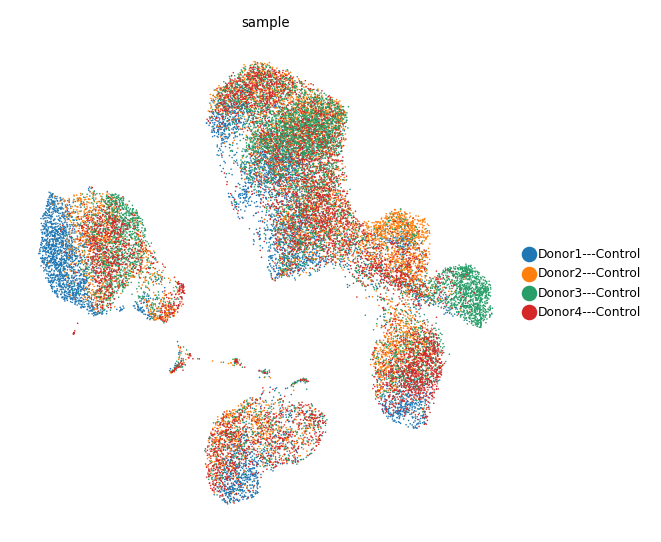

In [17]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

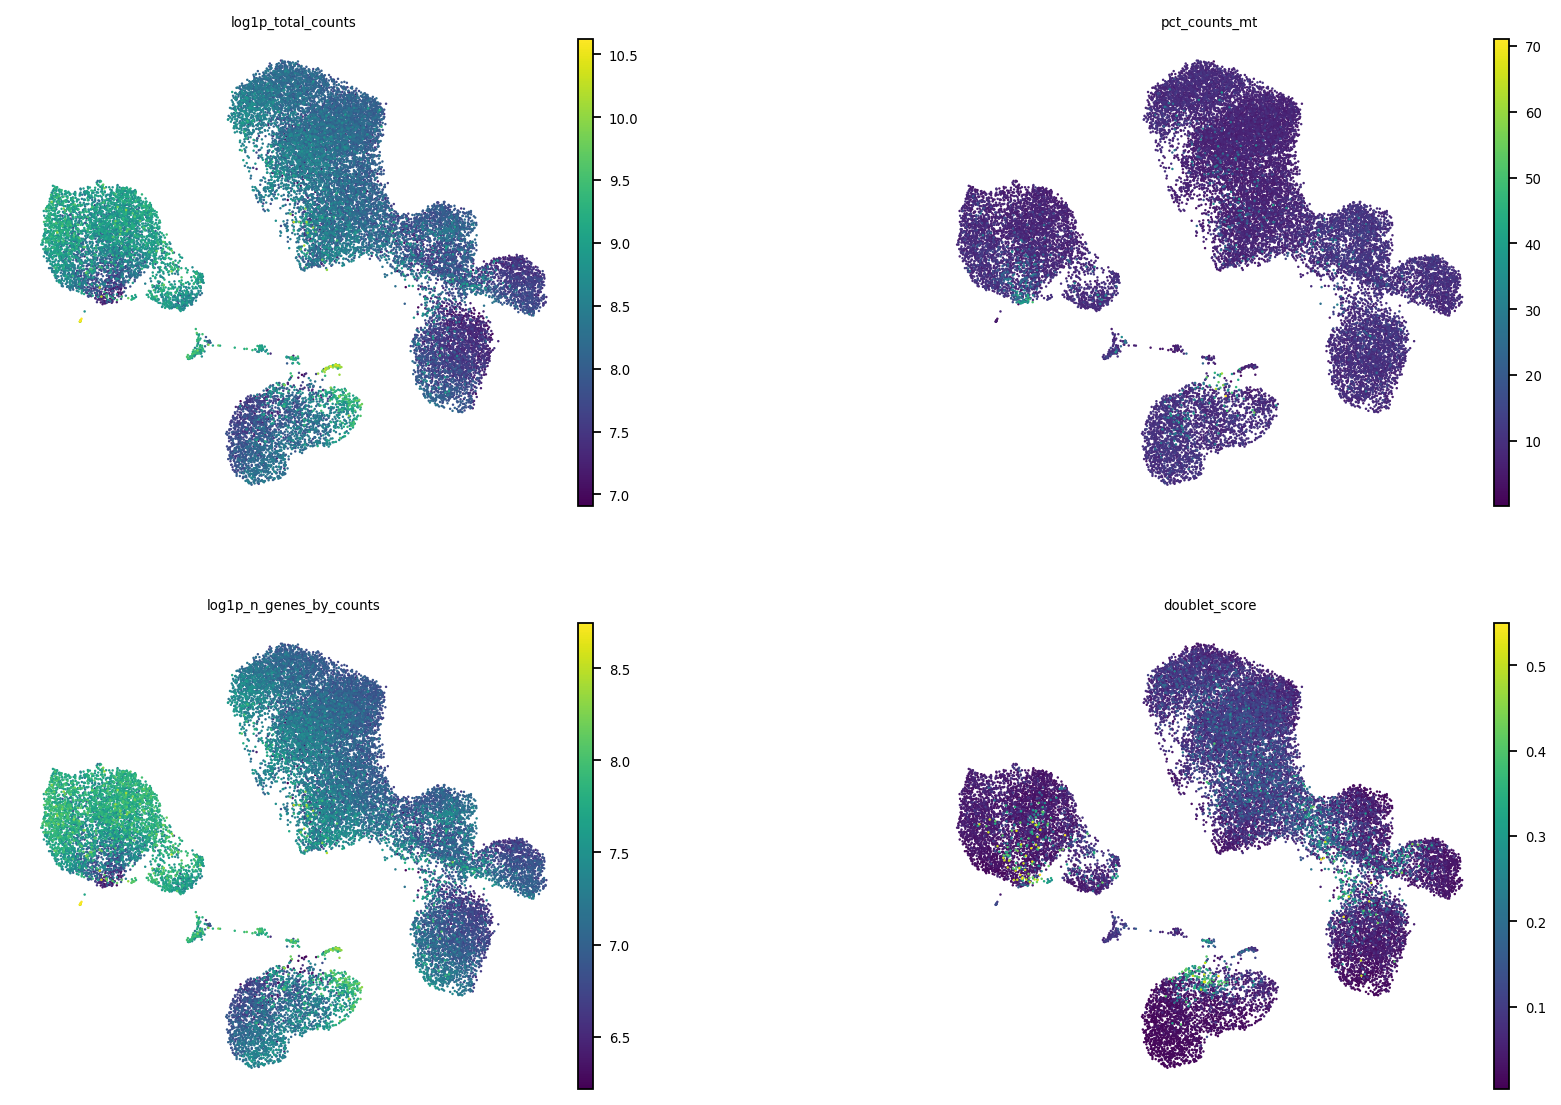

In [18]:
sc.pl.umap(
    adata,
    color=["log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts",  "doublet_score"],
    wspace=0.5,
    ncols=2,
)

In [19]:
#Check for number of cells with a doublet score over X
adata.obs['predicted_doublet_0.2'] = adata.obs['doublet_score'] > 0.20
adata.obs['predicted_doublet_0.25'] = adata.obs['doublet_score'] > 0.25

In [20]:
adata.obs['predicted_doublet_0.2'].value_counts()

predicted_doublet_0.2
False    23524
True       824
Name: count, dtype: int64

In [21]:
adata.obs['predicted_doublet_0.25'].value_counts()

predicted_doublet_0.25
False    23875
True       473
Name: count, dtype: int64

/tmp/ipykernel_2978155/1812218433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_doublet_0.2', y='doublet_score', data=adata.obs, palette="Set2")


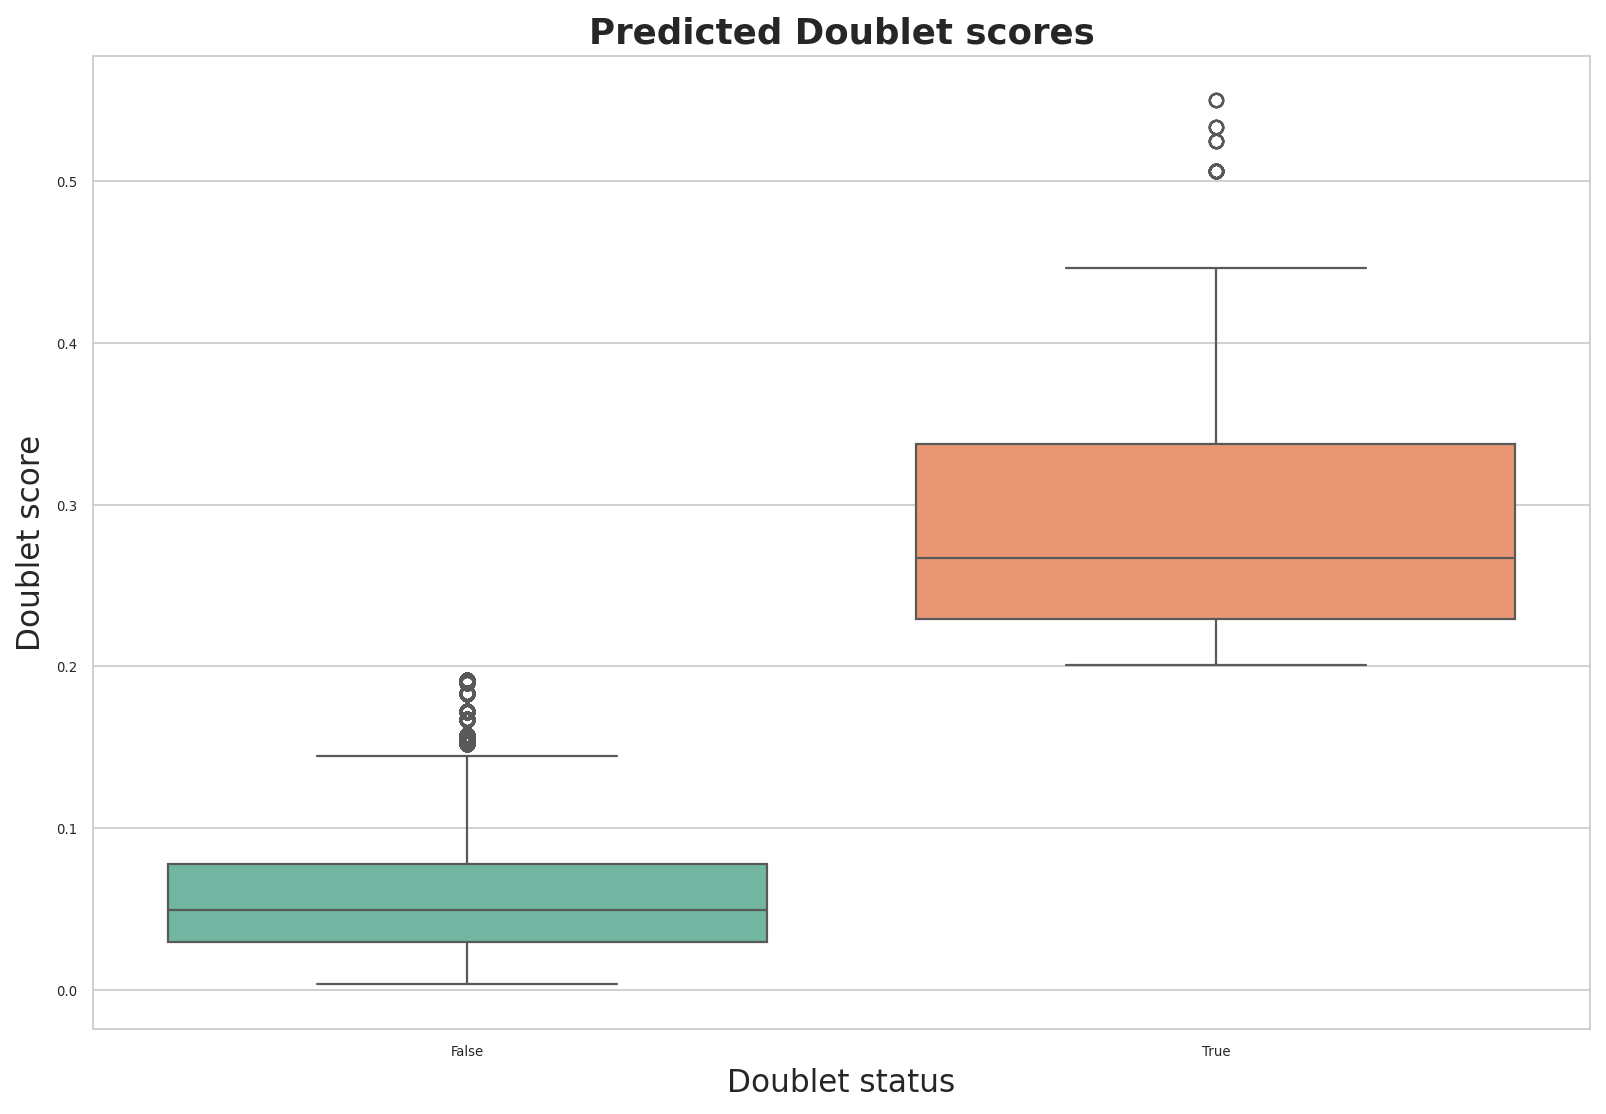

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))  
sns.boxplot(x='predicted_doublet_0.2', y='doublet_score', data=adata.obs, palette="Set2")

plt.title('Predicted Doublet scores', fontsize=16, fontweight='bold')
plt.xlabel('Doublet status', fontsize=14)
plt.ylabel('Doublet score', fontsize=14)

plt.show()

In [23]:
#Filter doublets
adata_filtered = adata[adata.obs['predicted_doublet_0.2']==False]
adata_filtered = adata_filtered[adata_filtered.obs['pct_counts_mt'] < 20.0]

In [24]:
adata_new = adata_filtered.raw.to_adata()

### Recluster filtered data

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 12
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)
running Leiden clustering


/tmp/ipykernel_2978155/2508929366.py:46: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 16 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:04)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.9', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:04)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_1.1', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_1.2', the cluster labels (adata.obs, categorical) (0:00:03)


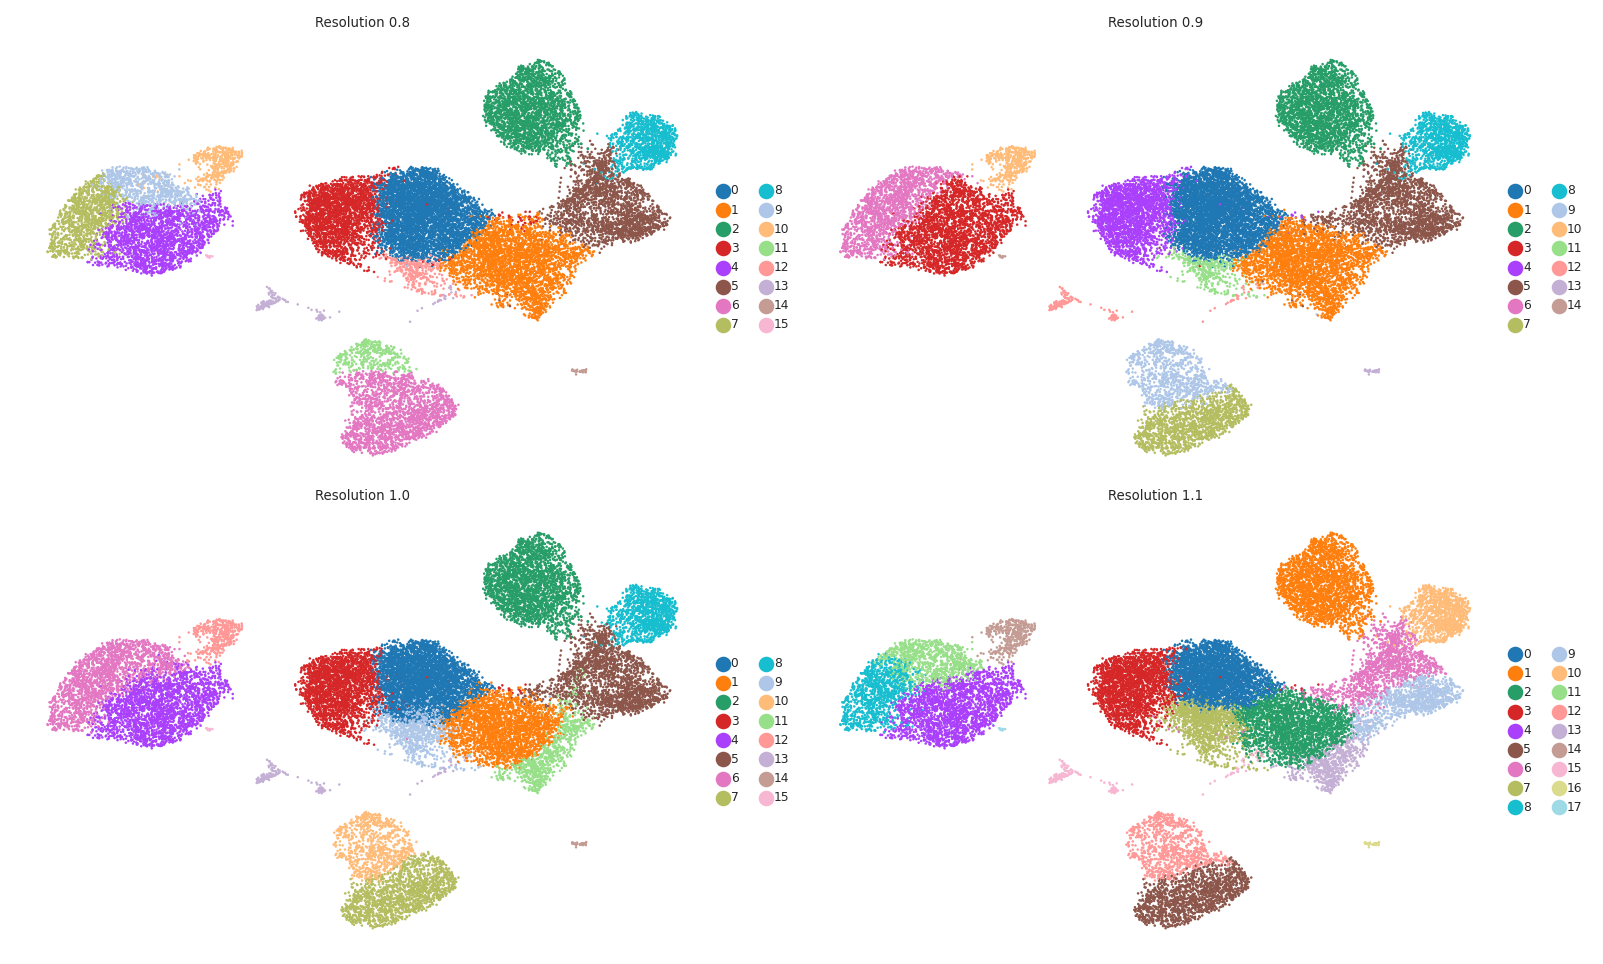

In [25]:
# Ensure the log1p base is set to None (default is natural log)
# This ensures that Scanpy's log1p function assumes natural logarithm scaling
adata_new.uns["log1p"]["base"] = None

# Identify highly variable genes (HVGs) across different samples
# This step helps to focus on the most informative genes
sc.pp.highly_variable_genes(adata_new, batch_key="sample")

# Store a copy of the raw data before subsetting
# This preserves full gene expression information for later reference
adata_new.raw = adata_new

# Subset the dataset to only include highly variable genes
# Reducing the number of features helps improve clustering accuracy
adata_new = adata_new[:, adata_new.var.highly_variable]

# Scale the data: zero-center and scale to unit variance
# The `max_value=10` prevents extreme values from distorting the analysis
sc.pp.scale(adata_new, max_value=10)

# Perform Principal Component Analysis (PCA) for dimensionality reduction
# Using `svd_solver="arpack"` ensures better handling of sparse matrices
sc.tl.pca(adata_new, svd_solver="arpack")

# Compute the k-nearest neighbors graph for downstream clustering and visualization
# Here, we use 12 principal components to define the neighborhood
sc.pp.neighbors(adata_new, n_pcs=12)

# Generate UMAP embeddings for visualization of cell clusters
sc.tl.umap(adata_new)

# Define a range of resolutions for Leiden clustering
# This tests different levels of granularity in clustering, from 0.8 to 1.2 (steps of 0.1)
resolutions = np.arange(0.8, 1.3, 0.1)

# Perform Leiden clustering for each resolution
for resolution in resolutions:
    key_added = f'leiden_{resolution:.1f}'  # Format key with one decimal place
    
    # Apply Leiden clustering with the specified resolution
    # A higher resolution results in more fine-grained clusters
    sc.tl.leiden(
        adata_new,
        resolution=resolution,
        random_state=0,  # Ensures reproducibility
        key_added=key_added
    )

# Define a different range for plotting (0.8 to 1.1)
resolutions = np.arange(0.8, 1.2, 0.1)

# Define grid dimensions for subplots
n_rows = 2  # Number of rows
n_cols = 2  # Number of columns
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 6))  # Adjust size as needed

# Flatten the axes array to facilitate iteration
axs = axs.flatten()

# Generate UMAP plots for different clustering resolutions
for i, resolution in enumerate(resolutions):
    key_added = f'leiden_{resolution:.1f}'  # Corresponding Leiden cluster annotation
    
    # Plot UMAP with Leiden clustering at the given resolution
    sc.pl.umap(
        adata_new,
        color=[key_added],  # Color points by cluster assignment
        title=f'Resolution {resolution:.1f}',  # Set title for clarity
        ax=axs[i],  # Assign to specific subplot
        show=False  # Suppress automatic display for controlled plotting
    )

# Adjust spacing to prevent overlapping plots
plt.tight_layout()

# Display all UMAP plots
plt.show()


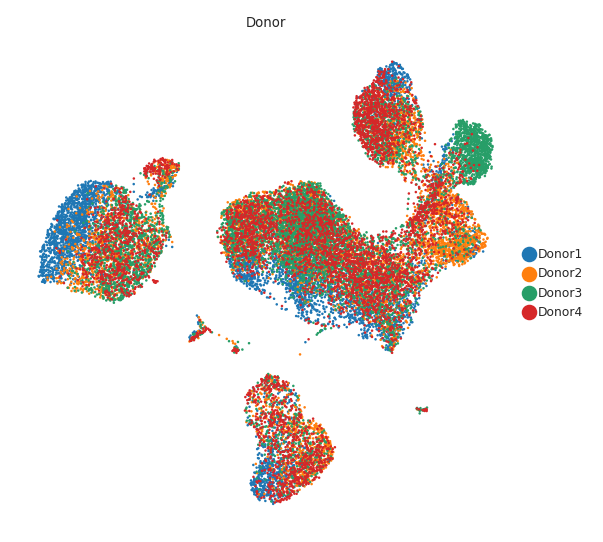

In [26]:
sc.pl.umap(adata_new, color=["Donor"])

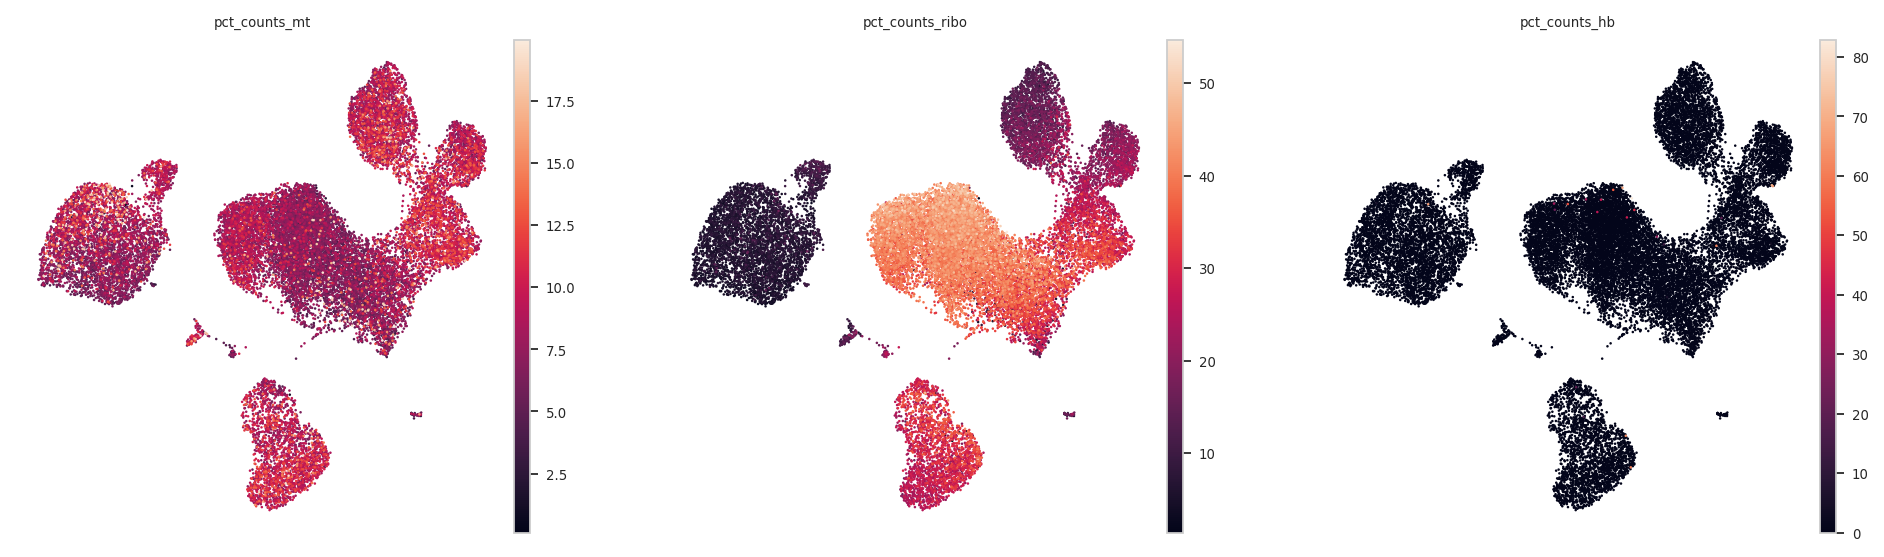

In [27]:

sc.pl.umap(adata_new, color=["pct_counts_mt","pct_counts_ribo","pct_counts_hb"])

ranking genes
    finished: added to `.uns['groups_genes_leiden_1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


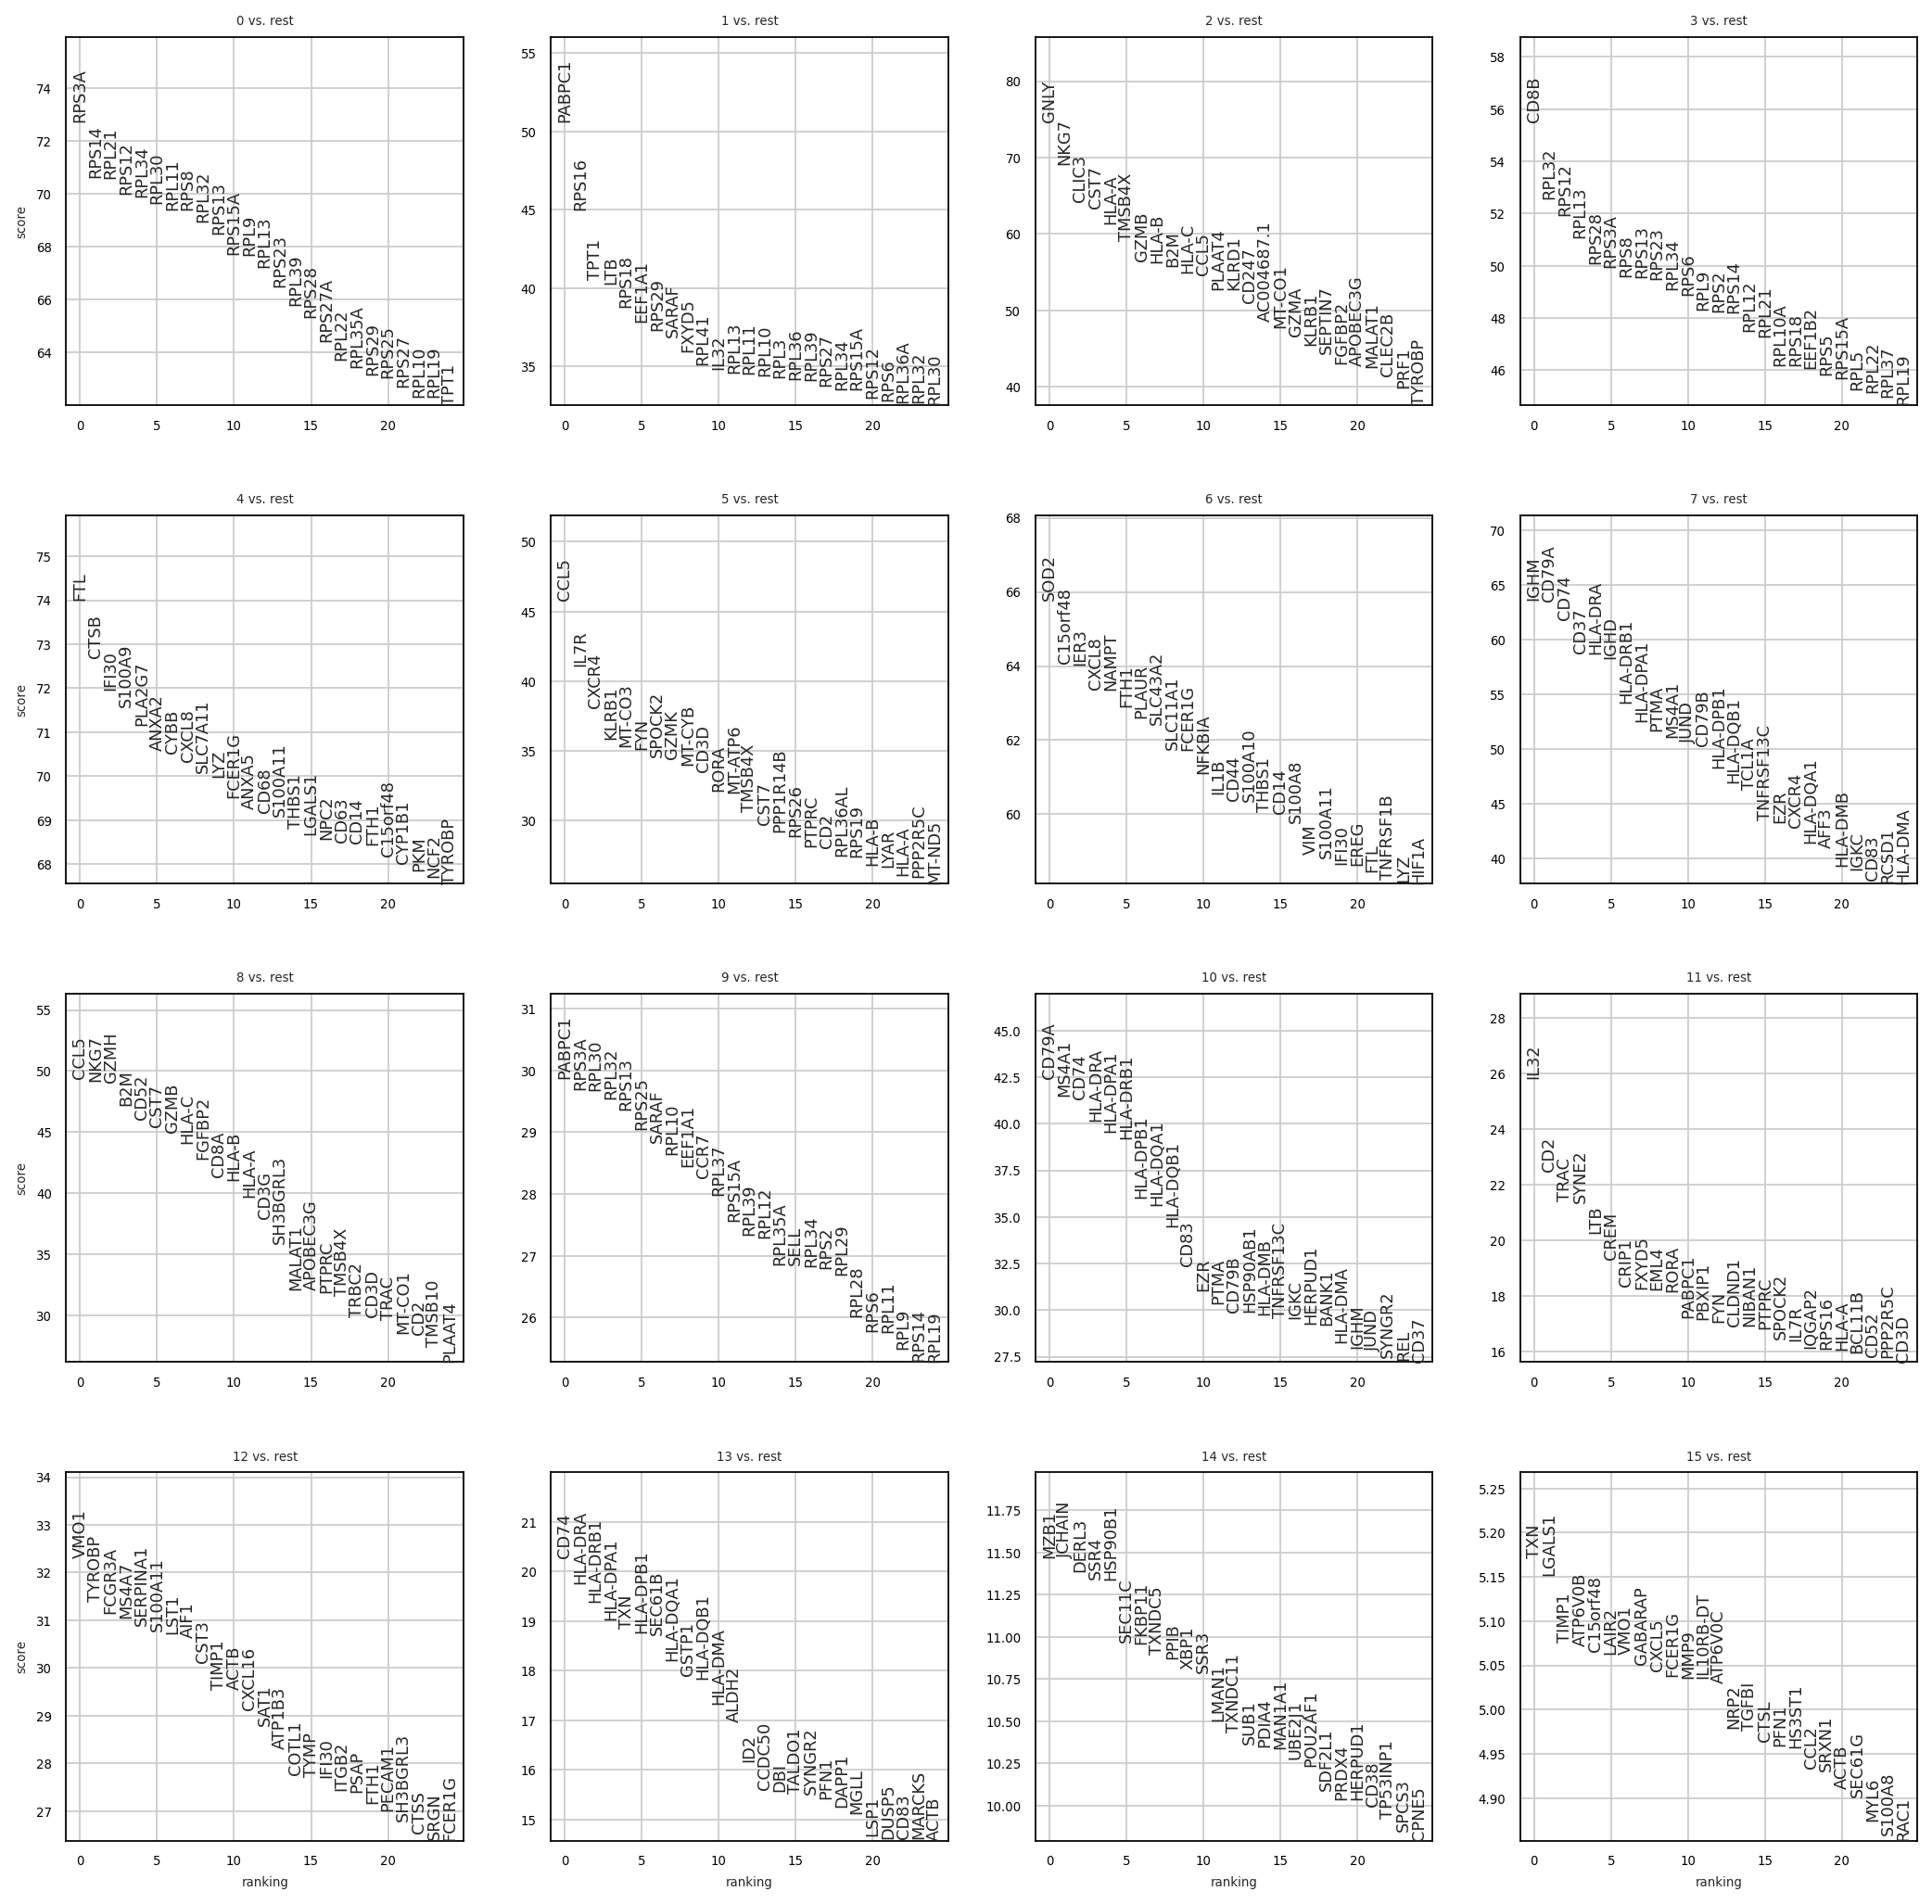

In [28]:
sc.set_figure_params(fontsize=6,frameon=False)
sc.tl.rank_genes_groups(adata_new, "leiden_1.0", method="wilcoxon",key_added='groups_genes_leiden_1')
sc.pl.rank_genes_groups(adata_new, n_genes=25, sharey=False,key='groups_genes_leiden_1')

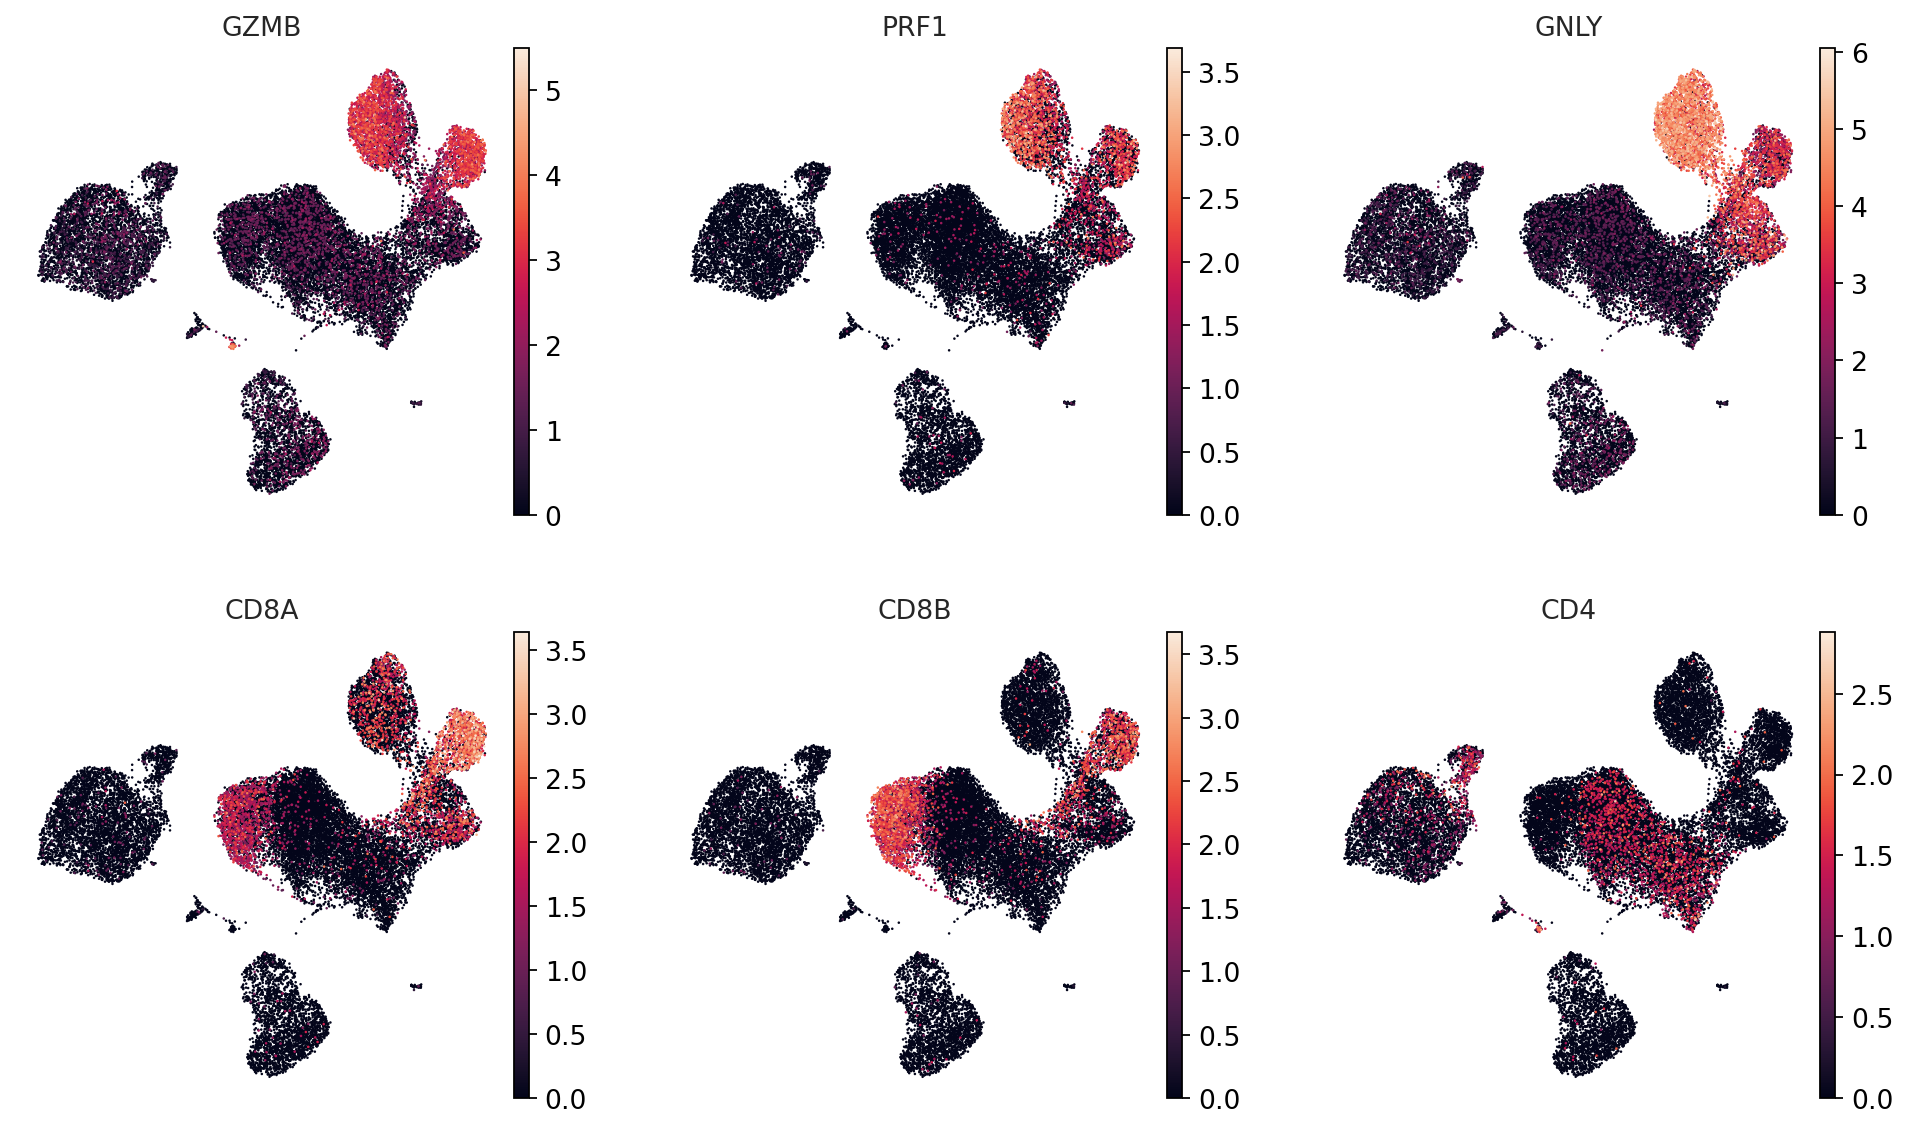

In [30]:
sc.set_figure_params(fontsize=12,frameon=False)
sc.pl.umap(adata_new, color= ['GZMB', 'PRF1', 'GNLY','CD8A','CD8B','CD4'],ncols=3)

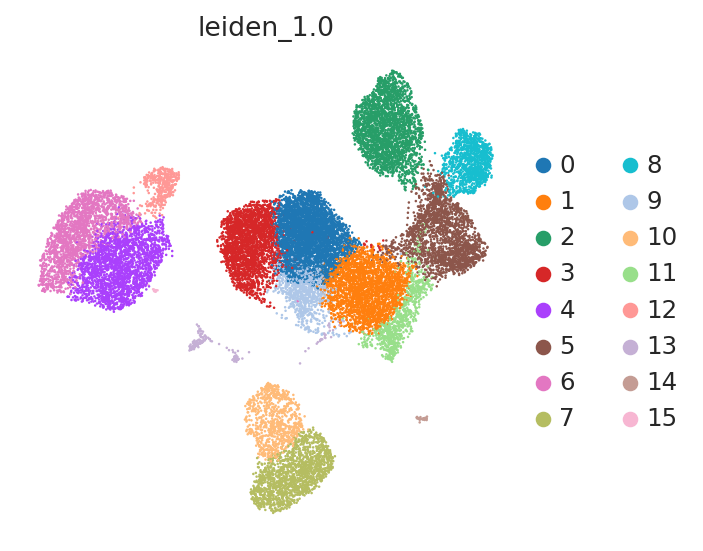

In [31]:
sc.pl.umap(adata_new, color=["leiden_1.0"])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_1.0']`
categories: 0, 1, 2, etc.
var_group_labels: CD14 Monocytes, FCGR3A Monocytes, DCs, etc.


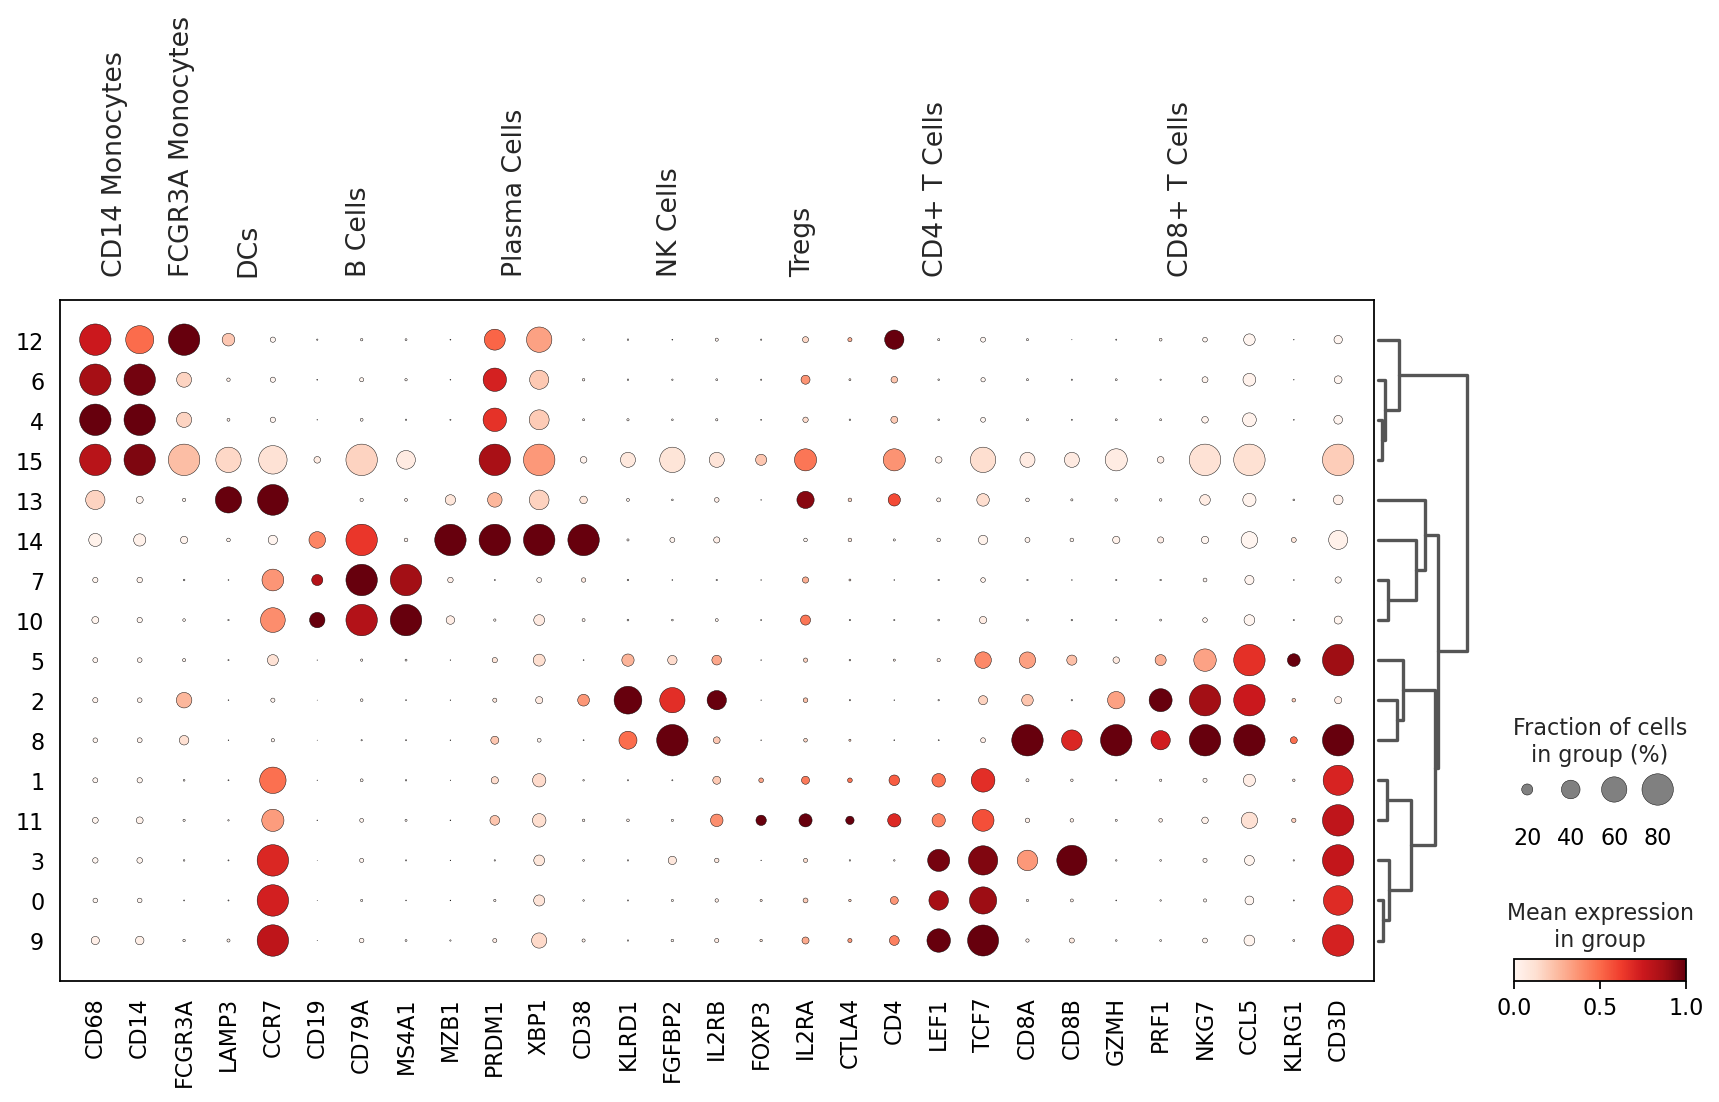

In [32]:
# Define a dictionary mapping cell types to key marker genes
# These markers help distinguish major immune populations
gene_dict = {
    'CD14 Monocytes': ['CD68', 'CD14'],
    'FCGR3A Monocytes': ['FCGR3A'],
    'DCs': ['LAMP3', 'CCR7'],
    'B Cells': ['CD19', 'CD79A', 'MS4A1'],
    'Plasma Cells': ['MZB1', 'PRDM1', 'XBP1', 'CD38'],
    'NK Cells': ['KLRD1', 'FGFBP2', 'IL2RB'],
    'Tregs': ['FOXP3', 'IL2RA', 'CTLA4'],
    'CD4+ T Cells': ['CD4', 'LEF1', 'TCF7'],
    'CD8+ T Cells': ['CD8A', 'CD8B', 'GZMH', 'PRF1', 'NKG7', 'CCL5', 'KLRG1', 'CD3D'],
}

# Generate a dot plot to visualize expression of marker genes across Leiden clusters
sc.pl.dotplot(
    adata_new,
    gene_dict,                  # Dictionary of marker genes grouped by cell type
    groupby="leiden_1.0",       # Group cells by Leiden clustering at resolution 1.0
    dot_min=0,                  # Minimum dot size (used for expression scaling)
    dot_max=0.8,                # Maximum dot size (prevents overly large dots)
    dendrogram=True,           # Show hierarchical clustering of groups (optional, helps with interpretation)
    standard_scale='var'       # Scale gene expression across variables (genes) for comparability
)


In [33]:
# Define a dictionary that maps Leiden cluster labels to broad immune cell types
# These labels are based on marker gene expression and biological interpretation
broad_cluster_names = {
    "0": "CD4+ T Cells",
    "1": "CD4+ T Cells",
    "2": "NK Cells",
    "3": "CD8+ Naive T Cells",
    "4": "CD14+ Monocytes",
    "5": "CD8+ Effector T Cells",
    "6": "CD14+ Monocytes",
    "7": "B Cells",
    "8": "CD8+ Effector T Cells",
    "9": "CD4+ T Cells",
    "10": "B Cells",
    "11": "CD4+ T Cells",
    "12": "CD16+ Monocytes",
    "13": "Dendritic Cells",
    "14": "Plasma Cells",
    "15": "CD14+ Monocytes"
}

# Map the broad cluster labels to the corresponding Leiden clusters
# This creates a new column 'Annotations_broad' with human-readable cell type names
adata_new.obs['Annotations_broad'] = adata_new.obs['leiden_1.0'].map(broad_cluster_names)


In [34]:
# Define a manual ordering of broad immune cell types
# This order can be based on lineage relationships, biological relevance, or visualization preference
manual_order = [
    'B Cells', 
    'CD14+ Monocytes', 
    'CD16+ Monocytes', 
    'Dendritic Cells', 
    'CD8+ Effector T Cells', 
    'CD8+ Naive T Cells', 
    'CD4+ T Cells', 
    'NK Cells', 
    'Plasma Cells'
]

# Convert the 'Annotations_broad' column to a categorical type with the specified order
# This ensures consistent ordering in visualizations (e.g., dot plots, bar plots, etc.)
adata_new.obs['Annotations_broad'] = pd.Categorical(
    adata_new.obs['Annotations_broad'],
    categories=manual_order,
    ordered=True
)


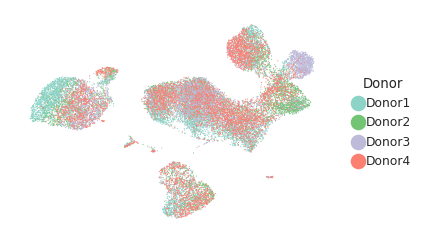

In [35]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set Scanpy figure parameters for uniform styling across plots
# `fontsize=6` keeps text compact; `frameon=False` removes unnecessary plot borders
sc.set_figure_params(fontsize=6, frameon=False)

# Define a custom color palette to use for donors
# Make sure the number of colors matches the number of unique donors
palette_cust = ['#8dd3c7', '#74c476', '#bebada', '#fb8072', '#80b1d3', 
                '#fdb462', '#b3de69', '#fccde5', '#ae017e', '#bc80bd']

# Initialize the figure and axes with desired size (width x height in inches)
fig, ax = plt.subplots(figsize=(2.5, 1.75))  # Small, compact format for publication

# Generate a UMAP plot, coloring cells by 'Donor'
sc.pl.umap(
    adata_new,
    color=['Donor'],       # Color by donor identity
    ncols=1,               # One panel per figure
    title="",              # No title for clean figure
    palette=palette_cust,  # Custom palette to match donor colors
    ax=ax,                 # Use predefined axes for fine control
    show=False,            # Delay showing so we can customize further
    size=1                 # Dot size (adjust based on cell density)
)

# Extract handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Add a custom legend to the side of the plot
legend = ax.legend(
    handles,
    labels,
    title='Donor',
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place legend just outside the plot area
    frameon=False                # Remove legend border
)

# Save the figure as a high-resolution PDF
plt.savefig(
    'Final_Notebooks/Figures/one_control/donor_1_control_slim.pdf',
    bbox_inches='tight',  # Tight layout for publication
    dpi=300                # High DPI for print-quality resolution
)

# Display the figure
plt.show(fig)


In [36]:
celltype_color_dict = {
    'B Cells': '#8dd3c7',
    'CD14+ Monocytes': '#74c476',
    'CD16+ Monocytes': '#bebada',
    'Dendritic Cells': '#fb8072',
    'CD8+ Effector T Cells': '#80b1d3',
    'CD8+ Naive T Cells': '#fdb462',
    'CD4+ T Cells': '#b3de69',
    'NK Cells': '#fccde5',
    'Plasma Cells': '#ae017e'
}


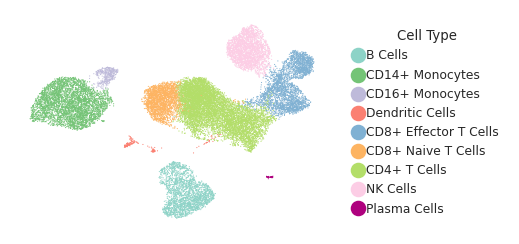

In [37]:
# Initialize figure and axis with small format (good for embedding in multi-panel figures)
fig, ax = plt.subplots(figsize=(2.5, 1.75))

# Generate UMAP plot colored by broad cell type annotations
sc.pl.umap(
    adata_new,
    color=["Annotations_broad"],     # Column in .obs containing broad cell type labels
    ncols=1,                          # Only one panel
    palette=celltype_color_dict,     # Custom color dictionary matching cell types
    title='',                         # No title for minimal figure style
    ax=ax,                            # Use specified axis object for controlled layout
    show=False,                       # Prevent immediate display so we can customize
    size=1,                           # Dot size (adjust depending on cell density)
    frameon=False                     # Remove frame around the UMAP for a cleaner look
)

# Extract legend handles and labels from the current axis
handles, labels = ax.get_legend_handles_labels()

# Add custom legend to the right side of the plot
legend = ax.legend(
    handles,
    labels,
    title='Cell Type',                # Legend title
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),       # Position legend just outside the plot
    frameon=False                     # Remove legend border
)

# Save the figure as a high-resolution PDF
plt.savefig(
    'Final_Notebooks/Figures/one_control/UMAP_1_control_slim.pdf',
    bbox_inches='tight',              # Trim whitespace around figure
    dpi=300                           # High-resolution output (suitable for publication)
)

# Display the plot
plt.show(fig)

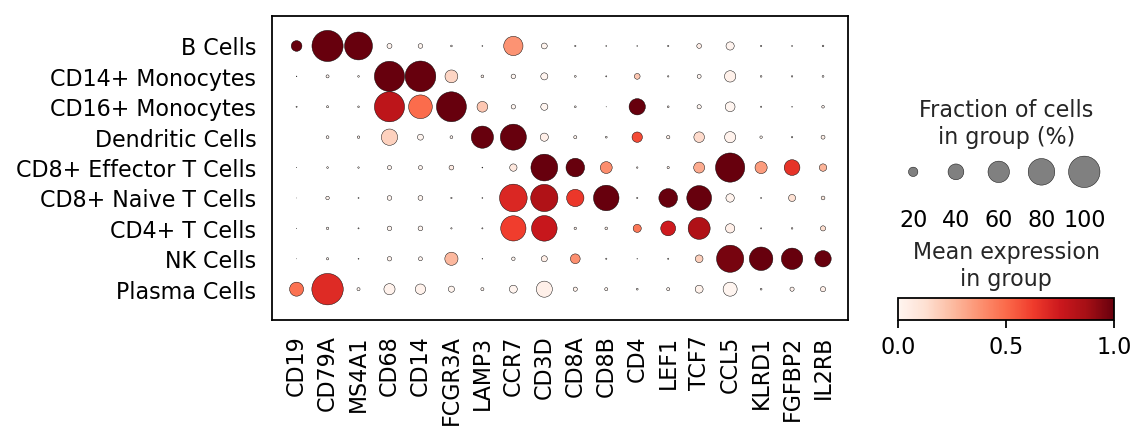

In [39]:
# Define a list of selected marker genes for major immune populations
genes = [
    'CD19', 'CD79A', 'MS4A1',          # B Cells
    'CD68', 'CD14', 'FCGR3A',          # Monocytes (CD14+ and FCGR3A+)
    'LAMP3', 'CCR7',                   # Dendritic Cells
    'CD3D', 'CD8A', 'CD8B',            # CD8+ T Cells
    'CD4', 'LEF1', 'TCF7',             # CD4+ T Cells
    'CCL5',                            # Effector T Cell marker
    'KLRD1', 'FGFBP2', 'IL2RB'         # NK Cells
]

# Set global figure parameters for consistent formatting across Scanpy plots
sc.set_figure_params(fontsize=12, frameon=False)

# Initialize the figure with specific dimensions (in inches)
fig, ax = plt.subplots(figsize=(6.75, 2.5))

# Generate a dot plot showing expression of selected genes across broad cell type annotations
sc.pl.dotplot(
    adata_new,
    genes,                             # Genes to plot
    groupby="Annotations_broad",      # Group by annotated cell types
    dot_min=0,                         # Minimum dot size
    dot_max=1,                         # Maximum dot size (tune to avoid overlapping)
    dendrogram=False,                 # Disable dendrogram for simplicity
    standard_scale='var',             # Scale gene expression across genes
    ax=ax,                             # Use pre-initialized axis for tight layout control
    show=False,
    figsize=(5.5, 1)                   # Adjust subplot size (may be overridden by `figsize` in `plt.subplots`)
)

# Save the figure in high-resolution PDF format for publication
plt.savefig(
    'Final_Notebooks/Figures/one_control/dotplot_1_control_slim.pdf',
    bbox_inches='tight',               # Remove extra whitespace
    dpi=300                            # High DPI for print quality
)

# Display the plot
plt.show(fig)


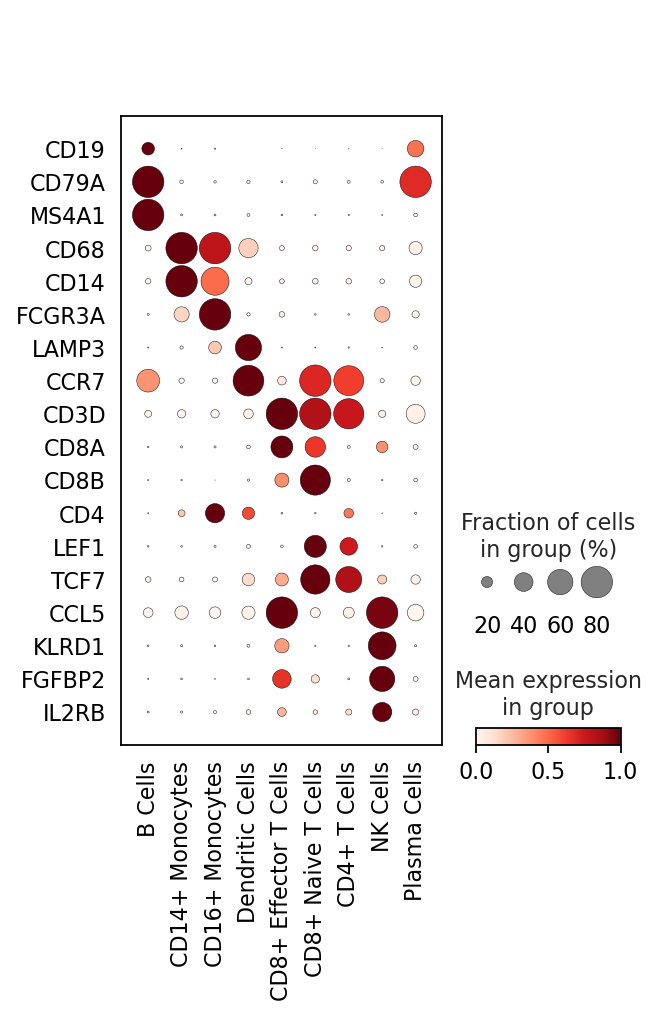

In [40]:
# Initialize the figure with vertical layout ? taller for text-heavy y-axis (genes)
fig, ax = plt.subplots(figsize=(4, 6))

# Set Scanpy's default figure parameters
sc.set_figure_params(fontsize=12, frameon=False)

# Generate dot plot with axes swapped: genes on y-axis, cell types on x-axis
sc.pl.dotplot(
    adata_new,
    genes,                             # List of marker genes to visualize
    groupby="Annotations_broad",      # Cell groupings to compare
    dot_min=0,                         # Minimum dot size for low expression
    dot_max=0.8,                       # Max dot size to avoid clutter
    dendrogram=False,                 # No clustering of groups
    standard_scale='var',             # Scale gene expression across genes
    ax=ax,                             # Use manually specified axis
    swap_axes=True,                   # Swap axes for better readability
    show=False                         # Suppress automatic display
)

# Save the dot plot in high-res PDF format
plt.savefig(
    'Final_Notebooks/Figures/one_control/dotplot_1_control_tight_text.pdf',
    bbox_inches='tight',              # Remove excess padding
    dpi=300                           # Publication-quality resolution
)

# Display the plot
plt.show(fig)

In [41]:
#Save h5ad object
adata_new.write("Final_Notebooks/Final_Objects/One_Control_analysis/PBMC_Clustered_Annotated.h5ad")

In [42]:
#Load h5ad object
adata_new = sc.read_h5ad("Final_Notebooks/Final_Objects/One_Control_analysis/PBMC_Clustered_Annotated.h5ad")
adata_new

AnnData object with n_obs × n_vars = 23096 × 1665
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'Annotations_broad'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean'

In [43]:
!pip list

Package                   Version
------------------------- --------------
adjustText                1.3.0
anndata                   0.10.9
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.9.1
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.8
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
et_xmlfile                2.0.0
exceptiongroup            1.2.2
executing    